<a href="https://colab.research.google.com/github/korakot/pythainlp_workshop/blob/master/notebooks/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wisesight Sentiment Analysis

This notebook details the steps taken to create a sentiment analyzer using data from [Wisesight Sentiment Analysis competition](https://www.kaggle.com/c/wisesight-sentiment/). Competition metric is overall accuracy across `neg`ative, `pos`itive, `neu`tral and `q`uestion classes. We give examples using logistic regression and [ULMFit](https://arxiv.org/abs/1801.06146).

The results for logistic regression, [fastText](https://fasttext.cc/), ULMFit, ULMFit with semi-supervised data are as follows:

| Model               | Public Accuracy | Private Accuracy |
|---------------------|-----------------|------------------|
| Logistic Regression | 0.72781         | 0.7499           |
| fastText            | 0.63144         | 0.6131           |
| ULMFit              | 0.71259         | 0.74194          |
| ULMFit Semi-supervised    | 0.73119     | 0.75859      |
| ULMFit Semi-supervised Repeated One Time    | **0.73372**     | **0.75968**      |

* For more information about the competition, see [1st Place Solution](https://www.kaggle.com/c/wisesight-sentiment/discussion/83564).
* For more updated version of data, including a tokenized `wisesight-1000` evaluation set, see [Wisesight Sentiment Corpus](https://github.com/PyThaiNLP/wisesight-sentiment).

In [1]:
#uncomment if you are running from google colab
!pip install sklearn_crfsuite
!pip install emoji
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
!pip install fastai
!wget https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip
!unzip master.zip
!mkdir wisesight_data

     |████████████████████████████████| 757kB 4.2MB/s 
     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=2665d90cd2017a107ae1a5ae6d53201f48bebe04d853faec3994bc4830ba58ed
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
     - 24.2MB 505kB/s
     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
  Created wheel for pythainlp: filename=pythainlp-2.2.0.dev0-cp36-none-any.whl size=12568248 sha256=107bfd3889fd598d0c254ef505de154261dab2382c7362d0f3d31c00c111e614
  Stored in directory: /tmp/pip-ephem-wheel-cache-bhcg4x77/wheels/79/4e/1e/26f3198c6712ecfbee92928ed1dde923a078da3d222401cc78
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=7bdaba5ede5bb6118d801ccf48f175484e489c3f445c5c71e92052e71300b833
  Stored in directory: /root/.cache/pip

--2020-03-02 01:59:44--  https://github.com/PyThaiNLP/wisesight-sentiment/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/master [following]
--2020-03-02 01:59:45--  https://codeload.github.com/PyThaiNLP/wisesight-sentiment/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ]   4.05M  2.66MB/s    in 1.5s    

2020-03-02 01:59:47 (2.66 MB/s) - ‘master.zip’ saved [4251880]

Archive:  master.zip
07e7d224affc4966ea10ad0e10b6bca6ad21c660
   creating: wisesight-sentiment-master/
  inflating: wisesight-sentiment-mas

In [2]:
#snippet to install thai font in matplotlib from https://gist.github.com/korakot/9d7f5db632351dc92607fdec72a4953f
import matplotlib
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
!cp thsarabunnew-webfont.ttf /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
!cp thsarabunnew-webfont.ttf /usr/share/fonts/truetype/
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='TH Sarabun New')

--2020-03-02 02:00:05--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-03-02 02:00:06--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00K  --.-KB/s    in 0.04s   

2020-03-02 02:00:07 (2.56 MB/s) - ‘thsara

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from pythainlp.ulmfit import process_thai

#viz
import matplotlib.pyplot as plt
import seaborn as sns

Corpus: wiki_lm_lstm
- Downloading: wiki_lm_lstm 0.32


100%|██████████| 1050919089/1050919089 [00:47<00:00, 21922371.22it/s]


Corpus: wiki_itos_lstm
- Downloading: wiki_itos_lstm 0.32


100%|██████████| 1530484/1530484 [00:00<00:00, 7527366.02it/s]


## Text Processor for Logistic Regression

`pythainlp.ulmfit.process_thai` contains text cleaning rules with the default aimed for sparse models like bag of words. It contains `pre_rules` applied before tokenization and `post_rules` applied after.

In [0]:
process_thai

In [4]:
from pythainlp.ulmfit import *
process_thai("บ้านนนนน ()อยู่นานนานนาน 😂🤣😃😄😅 PyThaiNLP amp;     www.google.com")

['บ้าน',
 'xxrep',
 '  ',
 'อยู่',
 'xxwrep',
 'นาน',
 '😂',
 '🤣',
 '😃',
 '😄',
 '😅',
 'pythainlp',
 '&',
 'xxurl']

## Process Text Files to CSVs

In [5]:
with open("wisesight-sentiment-master/kaggle-competition/train.txt") as f:
    texts = [line.strip() for line in f.readlines()]

with open("wisesight-sentiment-master/kaggle-competition/train_label.txt") as f:
    categories = [line.strip() for line in f.readlines()]

all_df = pd.DataFrame({"category":categories, "texts":texts})
all_df.to_csv('all_df.csv',index=False)
all_df.shape

(24063, 2)

In [6]:
with open("wisesight-sentiment-master/kaggle-competition/test.txt") as f:
    texts = [line.strip() for line in f.readlines()]

test_df = pd.DataFrame({"category":"test", "texts":texts})
test_df.shape

(2674, 2)

## Load Data

In [0]:
all_df["processed"] = all_df.texts.map(lambda x: "|".join(process_thai(x)))
all_df["wc"] = all_df.processed.map(lambda x: len(x.split("|")))
all_df["uwc"] = all_df.processed.map(lambda x: len(set(x.split("|"))))

test_df["processed"] = test_df.texts.map(lambda x: "|".join(process_thai(x)))
test_df["wc"] = test_df.processed.map(lambda x: len(x.split("|")))
test_df["uwc"] = test_df.processed.map(lambda x: len(set(x.split("|"))))

In [8]:
#prevalence
all_df.category.value_counts() / all_df.shape[0]

neu    0.544612
neg    0.255164
pos    0.178698
q      0.021527
Name: category, dtype: float64

## Train-validation Split

We perform 85/15 random train-validation split. We also perform under/oversampling to balance out the classes a little.

In [0]:
#when finding hyperparameters
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

#when actually doing it
# train_df = all_df.copy()
# valid_df = pd.read_csv('valid_df.csv')

In [10]:
valid_df.head()

,category,texts,processed,wc,uwc
0,neu,เห็นคนลบแอพ viu ก็เห็นใจและเข้าใจเขานะคะ แผลมั...,เห็น|คน|ลบ|แอ|พ|viu|ก็|เห็นใจ|และ|เข้าใจ|เขา|น...,48,43
1,neu,ไปชมไม้คิวของแชมป์ และรองแชมป์ กันจ้า! ..........,ไป|ชม|ไม้|คิว|ของ|แชมป์|และ|รอง|แชมป์|กัน|จ้า|...,43,41
2,neg,กลุ่มรถซีวิคเป็นกลุ่มที่น่ารำคานมากกกกกกกกก อว...,กลุ่ม|รถ|ซีวิค|เป็น|กลุ่ม|ที่|น่า|รำ|คาน|มาก|x...,47,36
3,neu,อยากสวยเหมือนเจ้าของแบรนด์สิคะ เนย โชติกา ใบหน...,อยาก|สวย|เหมือน|เจ้าของ|แบรนด์|สิ|คะ|เนย|โชติ|...,72,56
4,neg,ข้าวโถละร้อย แพง เพราะตักเป็นจานๆละ15 เต็มที่ก...,ข้าว|โถ|ละ|ร้อย|แพง|เพราะ|ตัก|เป็น|จาน|ๆ|ละ|15...,381,218


In [11]:
#prevalence
print(train_df["category"].value_counts() / train_df.shape[0])

neu    0.544957
neg    0.253557
pos    0.180071
q      0.021415
Name: category, dtype: float64


In [12]:
#prevalence
print(valid_df["category"].value_counts() / valid_df.shape[0])

neu    0.542659
neg    0.264266
pos    0.170914
q      0.022161
Name: category, dtype: float64


## Logistic Regression

### Create Features

In [0]:
#dependent variables
y_train = train_df["category"]
y_valid = valid_df["category"]

In [14]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df["texts"])
text_train = tfidf_fit.transform(train_df["texts"])
text_valid = tfidf_fit.transform(valid_df["texts"])
text_test = tfidf_fit.transform(test_df["texts"])
text_train.shape, text_valid.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((20453, 4616), (3610, 4616))

In [16]:
!wget https://raw.githubusercontent.com/PyThaiNLP/tutorials/master/source/notebooks/visualize.py

--2020-03-02 02:07:30--  https://raw.githubusercontent.com/PyThaiNLP/tutorials/master/source/notebooks/visualize.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3924 (3.8K) [text/plain]
Saving to: ‘visualize.py’

visualize.py        100%[===================>]   3.83K  --.-KB/s    in 0s      

2020-03-02 02:07:30 (110 MB/s) - ‘visualize.py’ saved [3924/3924]



In [17]:
#visualize texts
from visualize import top_feats_all, plot_top_feats
features = tfidf_fit.get_feature_names()
%time ts = top_feats_all(text_train.toarray(), y_train, features)
print(ts[0].shape)
ts[0].head()

CPU times: user 651 ms, sys: 472 ms, total: 1.12 s
Wall time: 1.12 s
(4616, 5)


,rank,feature,score,ngram,label
0,0,ไม่,0.029993,1,neg
1,1,กิน,0.022852,1,neg
2,2,xxrep,0.020228,1,neg
3,3,เลย,0.019493,1,neg
4,4,แต่,0.018151,1,neg


findfont: Font family ['TH Sarabun New'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TH Sarabun New'] not found. Falling back to DejaVu Sans.
findfont: Font family ['TH Sarabun New'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3656 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 3585 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211

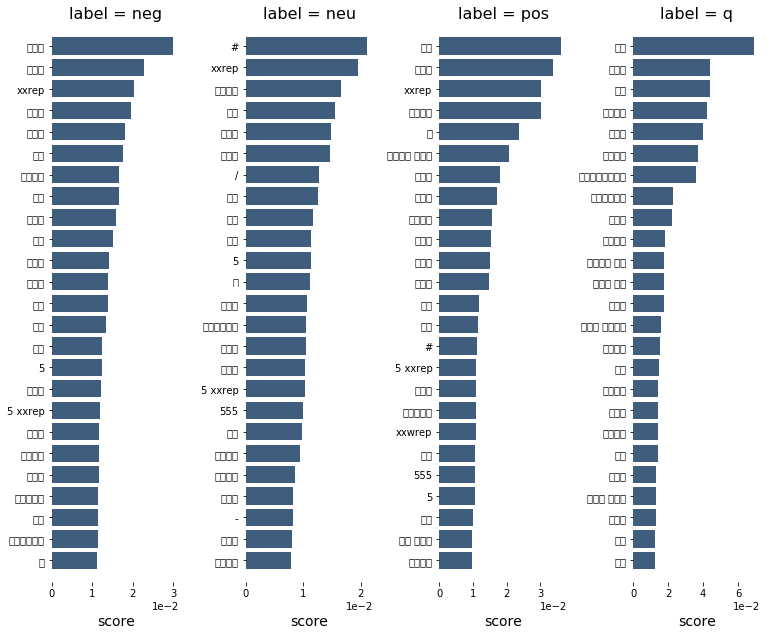

CPU times: user 1.22 s, sys: 49.1 ms, total: 1.27 s
Wall time: 1.28 s


In [18]:
%time plot_top_feats(ts)

In [0]:
#word count and unique word counts; actually might not be so useful
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(all_df[["wc","uwc"]].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)
num_train = scaler_fit.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler_fit.transform(valid_df[["wc","uwc"]].astype(float))
num_test = scaler_fit.transform(test_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

[21.96529942 18.22744462] [1151.47512883  513.46009207]


((20453, 2), (3610, 2))

In [0]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((20453, 4616), (3610, 4616))

### Fit Model

In [0]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.7324099722991689

### See Results

In [0]:
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["category"] = valid_df.category
probs_df["texts"] = valid_df.texts
probs_df["processed"] = valid_df.processed
probs_df["wc"] = valid_df.wc
probs_df["uwc"] = valid_df.uwc
probs_df["hit"] = (probs_df.preds==probs_df.category)
probs_df.to_csv("probs_df_linear.csv", index=False)

0.7324099722991689


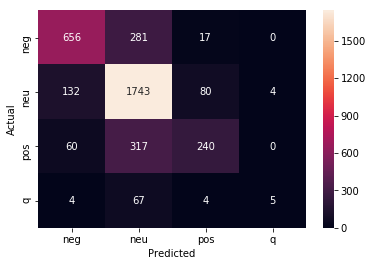

In [0]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## [ULMFit](https://github.com/cstorm125/thai2fit) Model

In [0]:
from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback
from pythainlp.ulmfit import *

model_path = "wisesight_data/"
all_df = pd.read_csv("all_df.csv")
train_df, valid_df = train_test_split(all_df, test_size=0.15, random_state=1412)

### Finetune Language Model

In [0]:
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=2)]

data_lm = (TextList.from_df(all_df, model_path, cols="texts", processor=processor)
    .split_by_rand_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=48))
data_lm.sanity_check()
data_lm.save('wisesight_lm.pkl')

In [0]:
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(23823, 240)

In [0]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=1., clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (23823 items)
x: LMTextList
xxbos   ประเทศ เรา ผลิต และ ส่งออก ยาสูบ เยอะ สุด ใน โลก จิง ป่าว คับ,xxbos   คะ,xxbos   อิ เหี้ย ออม ทำ กู อยาก กิน เอ็ม เค,xxbos   xxwrep 2 😅,xxbos   สวัสดี วัน พุธ   แนน   อะไร นะ
y: LMLabelList
,,,,
Path: wisesight_data;

Valid: LabelList (240 items)
x: LMTextList
xxbos   เห็น คน ลบ แอ พ   viu   ก็ เห็นใจ และ เข้าใจ เขา นะคะ   แผล มัน ยัง ใหม่ แถม อารมณ์ ยิ่ง โดน xxunk ง่าย อยู่ นี่ เนอะ 5   xxrep   7   ส่วน ทาง นี้ ก็ กอด   netflix   แน่น มาก   เธอ อย่า ทำร้าย เรา นะ   เรา รู้ เธอ ไม่ ทำร้าย เรา แน่นอน,xxbos   ไป ชม ไม้ คิว ของ แชมป์   และ รอง แชมป์   กัน จ้า !   .   xxrep   32   เก็บตก จาก การแข่งขัน   แสงโสม   สนุกเกอร์   6   แดง   โอเพ่น   ประจำปี   2560   สนาม ที่   2   ณ   มัง กี้   สนุกเกอร์   คลับ   ซอย โชค ชัย   4   ลาดพร้าว   เมื่อ วันที่   12   ต.ค. 60,xxbos   กลุ่ม รถ ซีวิค เป็น กลุ่ม ที่ น่า รำ คาน มาก   xxrep   9   อวด รถ กัน ได้ ทุก วินาที   อวด ทำไม มึง ก็ ใช้ รถ เหมือนกัน ทุกคน   ละ

In [0]:
#train frozen
print("training frozen")
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

training frozen


epoch,train_loss,valid_loss,accuracy,time
0,4.841187,4.462714,0.319742,02:47


In [0]:
#train unfrozen
print("training unfrozen")
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, moms=(0.8, 0.7))

training unfrozen


epoch,train_loss,valid_loss,accuracy,time
0,4.411834,4.205552,0.341766,03:31
1,4.178030,4.037095,0.361508,03:31
2,3.970388,3.930919,0.370139,03:31
3,3.756190,3.890398,0.376191,03:31
4,3.671704,3.890232,0.375595,03:31


In [0]:
# learn.save('wisesight_lm')
learn.save_encoder("wisesight_enc")

### Train Text Classifier

In [0]:
#lm data
data_lm = load_data(model_path, "wisesight_lm.pkl")
data_lm.sanity_check()

#classification data
tt = Tokenizer(tok_func=ThaiTokenizer, lang="th", pre_rules=pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=data_lm.vocab, max_vocab=60000, min_freq=20)]

data_cls = (ItemLists(model_path,train=TextList.from_df(train_df, model_path, cols=["texts"], processor=processor),
                     valid=TextList.from_df(valid_df, model_path, cols=["texts"], processor=processor))
    .label_from_df("category")
    .databunch(bs=50)
    )
data_cls.sanity_check()
print(len(data_cls.vocab.itos))

15000


In [0]:
#model
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False,
             output_p=0.4, hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
trn_args = dict(bptt=70, drop_mult=0.7, alpha=2, beta=1, max_len=500)

learn = text_classifier_learner(data_cls, AWD_LSTM, config=config, pretrained=False, **trn_args)
#load pretrained finetuned model
learn.load_encoder("wisesight_enc")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (20453 items)
x: TextList
xxbos   กันแดด คิว เพลส ตัวใหม่ นี่ คุม มัน ดีจริง อ่ะ   นี่ หน้า มัน   ยิ่ง ที โซน ยิ่ง มัน เยอะ   นีเวีย หลอด ยาว ๆ ฝา เขียว ก็ เอา ไม่อยู่ อ่ะ   แล้ว xxunk,xxbos   พบ กับ การ ร่วม ตัว ของ ศิลปิน   soul   pop   สาม ยุค   สาม สไตล์   ใน งาน   jamnight   อะไร ก็ช่าง xxunk   ( ชุ่ย )   นำ ทีม โดย   soul   after   six ,   the   parkinson   และ   the   xxup toys   งาน นี้ นอกจาก จะ ได้ ดู โชว์ แบบ เต็ม รูปแบบ จาก ทั้ง สาม วง แล้ว   ยัง มี โชว์ สุด พิเศษ ที่ ทั้ง สาม จะ ร่วม แจม กัน ด้วย   ไม่ อยาก ให้ พลาด   เจอกัน วันที่   29   กันยายน นี้ ที่ ช่าง ชุ่ย   ประตู เปิด   19.00   น. เป็นต้นไป   สามารถ ซื้อ บัตร ได้ แล้ว ที่   event   pop :   http :   /   /   go . eventpop . me   /   jamnight   * จำกัด ผู้ ที่ มีอายุ   20   ปี ขึ้นไป   #   jamnightbyjameson   #   jamesonthailand   #   soulaftersix   #   theparkinson   #   thetoys,xxbos   👌 🏻 👌 🏻 👌 🏻 xxwrep 2 😆,xxbos   จ - ศ   แถม ถึง   29   ไม่ทัน มะ ว้า   xxrep   

In [0]:
# #train unfrozen
# learn.freeze_to(-1)
# learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))
# learn.freeze_to(-2)
# learn.fit_one_cycle(1, slice(1e-2 / (2.6 ** 4), 1e-2), moms=(0.8, 0.7))
# learn.freeze_to(-3)
# learn.fit_one_cycle(1, slice(5e-3 / (2.6 ** 4), 5e-3), moms=(0.8, 0.7))
# learn.unfreeze()
# learn.fit_one_cycle(10, slice(1e-3 / (2.6 ** 4), 1e-3), moms=(0.8, 0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='bestmodel')])

Training takes about 20 minutes so we use the script `train_model.py` to do it with the following results (validation run):

```
epoch     train_loss  valid_loss  accuracy
1         0.812156    0.753478    0.687532
Total time: 00:56
epoch     train_loss  valid_loss  accuracy
1         0.740403    0.699093    0.714394
Total time: 00:57
epoch     train_loss  valid_loss  accuracy
1         0.727394    0.668807    0.723011
Total time: 01:34
epoch     train_loss  valid_loss  accuracy
1         0.722163    0.675351    0.723517
2         0.675266    0.654477    0.738723
3         0.669178    0.641070    0.737962
4         0.612528    0.637456    0.744551
5         0.618259    0.635149    0.749366
6         0.572621    0.651169    0.749873
7         0.561985    0.661739    0.747593
8         0.534753    0.673563    0.738469
9         0.530844    0.688871    0.746072
10        0.522788    0.670024    0.743031
Total time: 23:42
```

### See Results

In [0]:
learn.load("bestmodel")

#get predictions
probs, y_true, loss = learn.get_preds(ds_type = DatasetType.Valid, ordered=True, with_loss=True)
classes = learn.data.train_ds.classes
y_true = np.array([classes[i] for i in y_true.numpy()])
preds = np.array([classes[i] for i in probs.argmax(1).numpy()])
prob = probs.numpy()
loss = loss.numpy()

In [0]:
to_df = np.concatenate([y_true[:,None],preds[:,None],loss[:,None],prob],1)
probs_df = pd.DataFrame(to_df)
probs_df.columns = ["category","preds","loss"] + classes
probs_df["hit"] = (probs_df.category == probs_df.preds)
probs_df["texts"] = valid_df.texts
(y_true==preds).mean()

0.8392661555312158

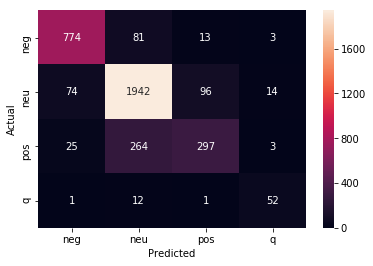

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=classes, yticklabels=classes)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()